学生証番号 :

名前 :

メールアドレス(法政大学) :

# B1-1 多項式近似 (polynomial curve fitting)と過学習

この実験は、実際に観測されるデータが、あるルール（関数）に従って生成されているという考え方に基づき、観測されたデータからそのルールを推定するというタスクを行う。
その現象を支配するルールが分かれば、データはいくらでも作成することができる、という生成モデルの考え方にも共通する。

ここでは、観測されたデータを元に、そのデータを生成した関数を推定する問題を扱う。
具体的には、多項式関数のパラメータ（係数）を推定する。


ここで得られる観測データ（＝学習データ）の数が少ない状況で、予測モデル（＝予測する関数）のパラメータが多い（＝自由度が高い）と、予測モデルは過学習(over-fitting, over-learning)を引き起こす。  
過学習は、教えられたデータに対しては極めて精度よく予測ができるが、本当に高い予測能が必要な未知のデータに対して精度が落ちる現象である。

過学習は、近年の機械学習の最も面倒な問題の１つである。
ここでは、簡単な例題を用いて過学習を体験する。




## 実験準備
この例題では、$N$個の観測された値、$ \mathbf{x} = \{x^{(1)}, x^{(2)}, \cdots, x^{
 (n)}, \cdots, x^{(N)}\}$, $ \mathbf{t} = \{t^{(1)}, t^{(2)}, \cdots, t^{(n)}, \cdots, t^{(N)}\}$ から、以下の多項式近似(polynomial curve fitting)を行い、観測された値が属する関数を推定する問題を扱う。 （モデルのパラメータ$W=\{w_0, w_1, ..., w_M\}$を推定する）

$
\begin{align}
 \tilde{y} = f(x) = w_0 + w_1 x + w_2 x^2 + \cdots +w_M x^M
\end{align}
$

今回、観測される各データ$(x_i, t_i)$は、真の分布（$y=\sin(x)$）に、平均0、標準偏差SD_noiseのノイズが付与されたN_samples個のデータのみが観測されていることを想定する。


今回の実験において、関数の定義域は[0～target_length] $\times \pi$とし、定義域内に、$x$の値を均等に生成する。

つまり$N$ペア存在する、$x^{(n)}$の値と、それに対応する観測値$t^{(n)}$のみから、未知の（本当に知りたい）関数に近い関数$f(x)$を構築するのがこの問題。コードでは$N$をN_samplesとしている。  
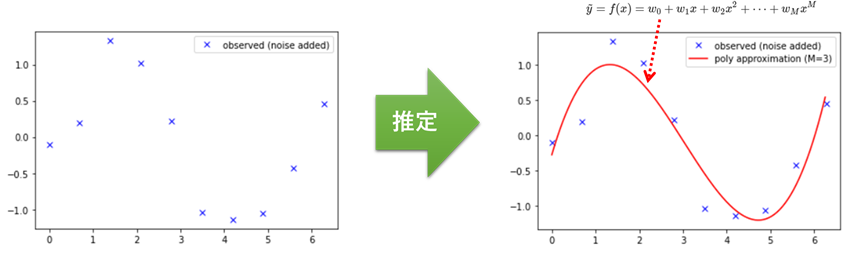



In [ ]:
# [1-0]
# ライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# [1-1]
#  データ作成の関数
# n_sampleはデータの個数、noise_sdはラベルに与えるノイズ
def get_data(n_sample, noise_sd):
    sx = np.linspace(0, 2 * np.pi, num=n_sample)
    noise = np.random.randn(n_sample) * noise_sd
    st = np.sin(sx) + noise
    # 今後の処理のために形式を整える
    sx = sx.reshape(-1, 1)
    st = st.reshape(-1, 1)
    return sx, st

次に、未知の(今回推定する目的となる)sin関数を作成して、描画する。 以下のxは、描画のために用意したx軸用の連続の値。

In [ ]:
# [1-2]
# 未知のsin関数の値はget_data関数のデータ数200, ノイズ0で作成する。
# この関数に近い関数を求めることが目的。ただしこの関数自体は未知なので、定量的な評価には使えない。
x, t = get_data(200, 0)
plt.plot(x, t, "g-")
plt.show()

get_data関数を用いて、n_sample個の観測されたデータ$\mathbf{x}$と観測値 $\mathbf{t}$を作成し、sin関数上にplotしてみる。


In [ ]:
# [1-3]
# sx, stはモデルの学習に使用する入力と予測したい出力に対応している。
sx, st = get_data(10, 0.1)

# 値のplot
plt.plot(x, t, "g-", label="real(unknown)")  # real（unknown) data
plt.plot(sx, st, "bx", label="observed (noise added)")  # observed data
plt.legend(loc="best")
plt.show()

実際のサイン関数(緑の線)と青の×点の差が今回与えたノイズになっている。

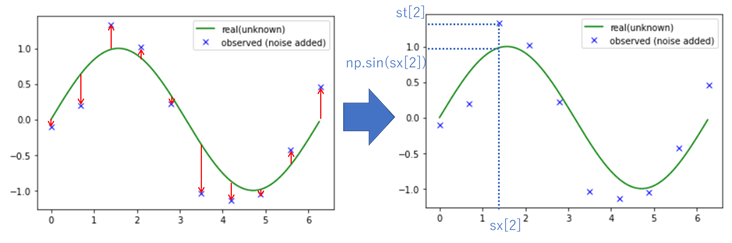

この青い観測データ（＝学習データ）を用いて、その現象を支配する緑の関数に近い、$f(x)$を求める

### 誤差関数を定義する ###

今回はまず、単純な2乗和誤差を使う。  
2乗和誤差$E$は、正解の値（今回の場合は観測値）$t^{(n)}$と、予測値$\tilde{y}^{(n)} = f(x^{(n)})$の差の2乗の値をすべてのデータ$n$に対して足しこんだものである。
$\mathbf{x} = \{x^{(1)}, x^{(2)}, \cdots, x^{(n)}, \cdots, x^{(N)}\}$


$$
E = \frac{1}{2}\sum_{n=1}^N (t^{(n)} - f(x^{(n)}))^2
$$
と書ける。

ここで定義した誤差関数$E$は、$x$に対する予測値$f(x)$, 与えられた観測値（この場合は答え）$t$の組み合わせから、2乗誤差を返す関数である。この問題では$x$も$t$もスカラ量であるが、一般的な問題では$x$と$t$はベクトル(多次元データ)である。

In [ ]:
# [1-4]
# 二乗誤差関数Eの定義
# predが予測値でtが観測値
# (2025 predict関数の更新に対応するため updated)
def error(pred, t):
  y_pred = np.ravel(pred)
  y_true = np.ravel(t)
  return np.sum((y_true - y_pred) ** 2)

In [ ]:
# [1-5]
# 実際に値をいくつか入力して確認してみる
true = np.array([0, 1, 2, 3, 4, 5])
best_predict = np.array([0, 1, 2, 3, 4, 5])
bad_predict = np.array([5, 4, 3, 2, 1, 0])

print("完全に予測できているとき : ", error(best_predict, true))
print("でたらめな予測をしているとき : ", error(bad_predict, true))

### 予測する関数 $f(x)$を作成する。
polynomial curve fitting （累乗関数近似）により、観測された$N$組の$(x^{(n)}, t^{(n)})$から、先に定義した二乗和誤差$E$が最も少なくなるように、モデルのパラメータ$W$を推定する。

まず、多項式特徴量を作るために、sklearnという科学計算ライブラリにあるPolynomialFeatures (sklearn.preprocessing.PolynomialFeatures)を利用する。

近似には、LinearRegression(sklearn.linear_model.LinearRegression)を使う。

最初に$M=1$、多項式特徴なし（つまり$y=w_1x+w_0$の関数）で近似を行う。

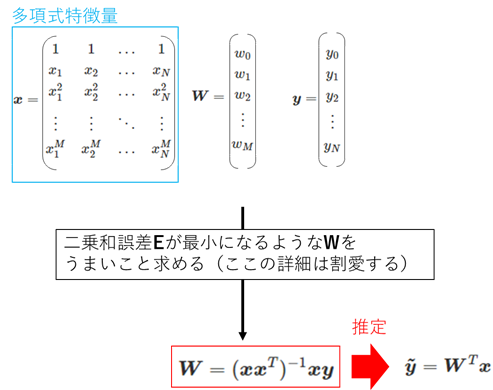

In [ ]:
# [1-6]
# 必要ライブラリのインポート
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# [1-7]
# 多項式特徴を作成するPolynomialFeaturesのインスタンスを作成
poly1 = PolynomialFeatures(degree=1)  # degree がMと対応している

# fit_transformで多項式特徴量の生成
sx_poly1 = poly1.fit_transform(sx)
x_poly1 = poly1.transform(x)

# 多項式特徴量の確認
print(sx_poly1)

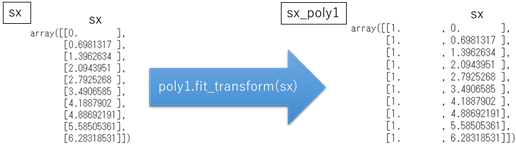

In [ ]:
# [1-8]
# 近似のための回帰モデルのインスタンスmodel1を作成
model1 = LinearRegression(fit_intercept=False)

# パラメータを推測する(近似する)
model1.fit(sx_poly1, st)

作ったモデルの動作確認。

In [ ]:
# [1-9]
# sxへの予測
pred1 = model1.predict(sx_poly1)

# 係数の確認
print("係数；", model1.coef_)

# 　予測結果
print("出力：", pred1)

# 　予測値 model1.predict(x)と、観測値(t)の違いである残差
print("残差：", error(pred1, st))

係数は、$w_0, w_1, \cdots ,w_M$の順。


次に、グラフを描いて確認してみる。グラフの作成はこの後何回も行うので、関数にしておく。

In [ ]:
# [1-10]
# モデルの予測のグラフを描く関数の作成
# predictにはxに対する予測結果、Mには今回使用した多項式近似のパラメータMを与える。
def plot_predict(predict, M):
    # 誤差の表示
    print("誤差 : ", error(predict, t))
    # グラフのプロット
    plt.plot(x, t, "g-", label="real(unknown)")  # real（unknown) data
    plt.plot(sx, st, "bx", label="observed (noise added)")  # observed data
    plt.plot(
        x, predict, "r-", label=f"linear approximation (M={M})"
    )  # estimated function
    plt.legend(loc="best")
    plt.show()

In [ ]:
# [1-11]
# poly 1の予測結果を出す。
poly1_predict = model1.predict(x_poly1)
plot_predict(poly1_predict, 1)

次にM=5,つまり5次の近似式を作成する。以下同様。

In [ ]:
# [1-12]
# 今度はM=5を試す
poly5 = PolynomialFeatures(degree=5)
sx_poly5 = poly5.fit_transform(sx)
x_poly5 = poly5.transform(x)

# M=5多項式モデルmodel3を作成
model5 = LinearRegression(fit_intercept=False)
model5.fit(sx_poly5, st)
print("観測データの誤差 : ", error(model5.predict(sx_poly5), st))

# 予測
poly5_predict = model5.predict(x_poly5)

# グラフの描画
plot_predict(poly5_predict, 5)

今度はM=9を試す。(9次の累乗関数）の構築

In [ ]:
# [1-13]
# 今度はM=9を試す
poly9 = PolynomialFeatures(degree=9)
sx_poly9 = poly9.fit_transform(sx)
x_poly9 = poly9.transform(x)

# M=5多項式モデルmodel3を作成
model9 = LinearRegression(fit_intercept=False)
model9.fit(sx_poly9, st)
print("観測データの誤差 : ", error(model9.predict(sx_poly9), st))

# 予測
poly9_predict = model9.predict(x_poly9)

# グラフの描画
plot_predict(poly9_predict, 9)

### 課題B1-1-1  Mの変化で予測はどう変化していくか。

Mを大きくしていくとどうなったか？　データの数（観測数）が増やしてみるとどうなるか？
いろいろな条件を試してデータ数とMの値について考察せよ。
また、極めて単純な例だがモデルが過学習を起こさないようにするためにはどのようにすればよいか考えよ。

ヒント :

- データ数は以下のコードをコピペして、n_sampleの値を変えることで変更できます(現在 : 10)
```
n_sample = 10
sx, st = get_data(n_sample, 0.1)
```
- Mの値は以下のコードをコピペして、Mの値を変えることで変更できます(現在 : 9)
```
M = 9
poly = PolynomialFeatures(degree=M)
sx_poly = poly.fit_transform(sx)
x_poly = poly.transform(x)
model = LinearRegression(fit_intercept=False)
model.fit(sx_poly, st)
print("観測データの誤差 : ", error(model.predict(sx_poly), st))
predict = model.predict(x_poly)
plot_predict(predict, M)
```


In [ ]:
### いろいろな条件で実験を行い、以下のセルにどうなったかを簡潔にまとめよ。セルの数は自由に増やしてOK.

ここの部分に、試したことと、その結果を以下にまとめる。

 -
 -

## より洗練された誤差関数の導入　（正則化 regularization)の導入

これまでは、誤差の評価に、実際の値と、予測値の2乗和を誤差として
$$
E = \frac{1}{2} \sum_{n=1}^N  (t^{(n)}-f(x^{(n)}))^2
$$

用いていた。
この場合、モデルの自由度（自由になるパラメータ数）が増えると、モデルは学習データに過度に適合し汎用性を失う。
それを抑える方法として正則化(regularization）がある。

今回、新しくL2ノルム正則化項と呼ばれる新しい罰則を導入した新しい誤差関数を定義する。
$$
E_{L2} = \sum_{n=1}^N  (t^{(n)}-f(x^{(n)}))^2 + \frac{\lambda}{2} ||W||_2^2
$$
ここでベクトル$W=[w_1, w_2, \cdots, w_M]^T$は、全てのモデルパラメータ（今回なら数式を特徴づける係数）を要素にもつベクトルである。
$$
||W||_2 = \sqrt{w_1^2 + w_2^2 + \cdots +w_M^2}
$$

$||W||^2 $は、ベクトル$W$のL2のノルムと呼ばれる量であり、$M$次元空間におけるベクトルの長さ（大きさ）を表す。  

$\lambda$は2乗誤差の項と、追加した$W$のL2ノルムのバランスを取るための非負のパラメータ$(\lambda >0)$である。

この新しい誤差関数$E_{L2}$を最小化するということは、単にモデルが学習用データに近づくことだけではなく、同時に$W$の絶対値を小さくすることに相当する。

この誤差関数を用いて関数近似を行う回帰問題の事を、リッジ回帰(Ridge regression)という。ridgeというのは山の峰のことを指しており、L2ノルムの形状がとんがっていることに由来する。（とがっている向きが逆だが気にしない）

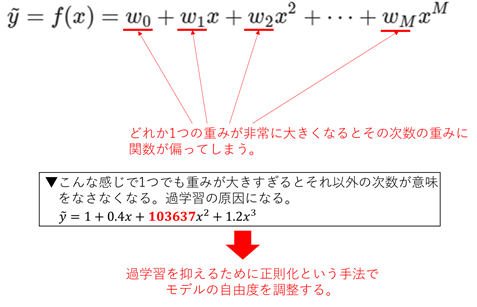

Ridge regressionは、sklearnのRidge(sklearn.linear_model.Ridge)を利用する。

In [ ]:
# [2-1]
# 再度データを定義
sx, st = get_data(10, 0.1)

# M=9の多項式特徴量を生成する。
M = 9
poly9 = PolynomialFeatures(degree=M)
sx_poly9 = poly9.fit_transform(sx)
x_poly9 = poly9.transform(x)

In [ ]:
# [2-2]
# 正則化項のないモデルで再度近似
model9 = LinearRegression(fit_intercept=False)
model9.fit(sx_poly9, st)
print("観測データの誤差 : ", error(model9.predict(sx_poly9), st))
poly9_predict = model9.predict(x_poly9)

In [ ]:
# [2-3]
# 正則化項のないモデルの係数をグラフで確認。
param_name = [f"w{i}" for i in range(10)]
plt.bar(param_name, model9.coef_.squeeze())

In [ ]:
# [2-3]
# モデルのインポート
from sklearn.linear_model import Ridge

# 正則化項を加えたridgeモデルで近似
alpha = 0.01
ridge = Ridge(alpha, fit_intercept=False)
ridge.fit(sx_poly9, st)
ridge_predict = ridge.predict(x_poly9)

In [ ]:
# [2-3]
# xsへの予測
pred = ridge.predict(sx_poly9)

# 係数の確認
print("係数；", ridge.coef_)

# モデルの予測結果
print("出力：", pred)

# 　予測値 predと、観測値(t)の違いである残差
print("残差：", error(pred, st))

In [ ]:
# [2-3]
# Ridgeモデルの係数をグラフで確認。
param_name = [f"w{i}" for i in range(10)]
plt.bar(param_name, ridge.coef_.squeeze())

In [ ]:
# [2-4]
# 誤差の確認
print("観測データの誤差 : ", error(ridge.predict(sx_poly9), st))
print("未知データの誤差 : ", error(ridge.predict(x_poly9), t))
# グラフの描画
plt.plot(x, t, "g-", label="real(unknown)")  # real（unknown) data
plt.plot(sx, st, "bx", label="observed (noise added)")  # observed data
plt.plot(x, poly9_predict, "r-", label="poly approximation (M=9)")  # estimated
# estimated with L2 regularizer
plt.plot(x, ridge_predict, "c-", label=f"ridge regression (M={M})")
plt.legend(loc="best")
plt.show()

### 課題 B1-1-2 $\lambda$の変化で予測はどのように変化していくか。
L2正則化項を追加する関数近似問題を解いて、過学習を抑制するにはどのようにするべきか。正則化係数$\lambda$の値はどのような値が望ましいのか、自分でいろいろいろと試した上で、最終的な考察を以下にまとめよ。

ヒント:
- $\lambda$の値はコードをコピペし、値を変えることで変更できます(現在 : 0.01)
```
alpha = 0.01
M = 9
poly = PolynomialFeatures(degree=M)
sx_poly = poly.fit_transform(sx)
x_poly = poly.transform(x)
model = LinearRegression(fit_intercept=False)
model.fit(sx_poly, st)
predict = model.predict(x_poly)
ridge = Ridge(alpha, fit_intercept=False)
ridge.fit(sx_poly, st)
ridge_predict = ridge.predict(x_poly)
print("正則化なしの誤差 : ", error(model.predict(x_poly9), t))
print("正則化ありの誤差 : ", error(ridge.predict(x_poly9), t))
plt.plot(x, t, "g-", label="real(unknown)")
plt.plot(sx, st, "bx", label="observed (noise added)")
plt.plot(x, predict, "r-", label=f"poly approximation (M={M})")
plt.plot(x, ridge_predict, "c-", label=f"ridge regression (M={M})")
plt.legend(loc="best")
plt.show()
```
- $\lambda$の値は$10^n (n = ..., -3, -2, -1, 0, 1, 2,3..)$のように大きく値を動かすと傾向が見やすい

In [ ]:
### ここ以下のセルに様々な実験を行え。セルの数は自由に増やしてOK.

ここの部分に、試したことと、その結果を以下にまとめる。

-
-

  